In [17]:
# %%
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='InceptionV3')
parser.add_argument('--weights', type=str, default='radimagenet')
parser.add_argument('--n_layers', type=int, default=4)
parser.add_argument('--n_neurons', type=int, default=256)
parser.add_argument('--n_dropout', type=float, default=0.0)
parser.add_argument('--lr_1', type=float, default=3e-4)
parser.add_argument('--lr_2', type=float, default=3e-6)
parser.add_argument('--image_size', type=int, default=512, required=False)
parser.add_argument('--batch_size', type=int, default=16, required=False)

args = parser.parse_args("")

model_name = args.model_name
weights = args.weights
n_layers = args.n_layers
n_neurons = args.n_neurons
n_dropout = args.n_dropout
lr_1 = args.lr_1
lr_2 = args.lr_2
img_size = args.image_size
batch_size = args.batch_size


In [18]:
# %%
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, InceptionV3, DenseNet121, Xception
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score
import keras_cv


# %%
train_dir = '../data/split_1/train'
val_dir = '../data/split_1/val'
test_dir = '../data/split_1/test'


# %%
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb', crop_to_aspect_ratio=False)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb', crop_to_aspect_ratio=False)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', seed=0, image_size=(img_size, img_size), batch_size=1, color_mode='rgb', crop_to_aspect_ratio=False)


# %%
#Apply data augmentation
preprocessing_model = tf.keras.Sequential()
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomRotation(40))
# preprocessing_model.add(
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2))
# preprocessing_model.add(
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
preprocessing_model.add(
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode="vertical"))
#add cutmix augmentation
# preprocessing_model.add(keras_cv.augmentations.CutMix(batch_size=batch_size, img_size=img_size, n_classes=2, alpha=1.0, prob=0.5))
#add random cutout augmentation
preprocessing_model.add(keras_cv.layers.RandomCutout(0.5, 0.5))


# %%
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


Found 492 files belonging to 2 classes.
Found 165 files belonging to 2 classes.
Found 164 files belonging to 2 classes.


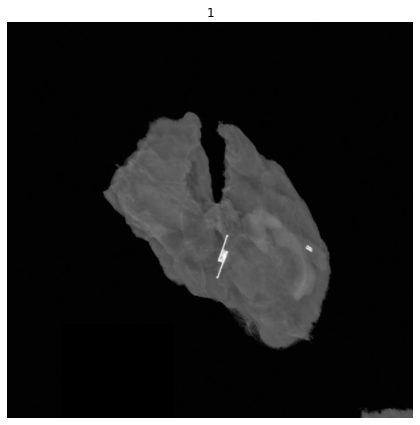

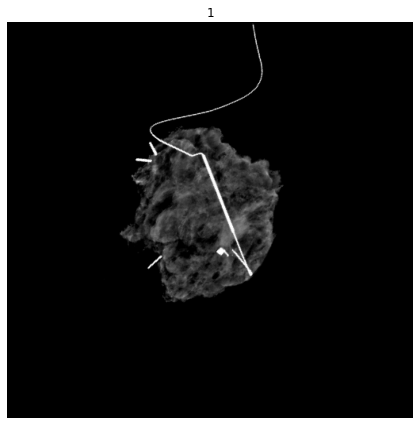

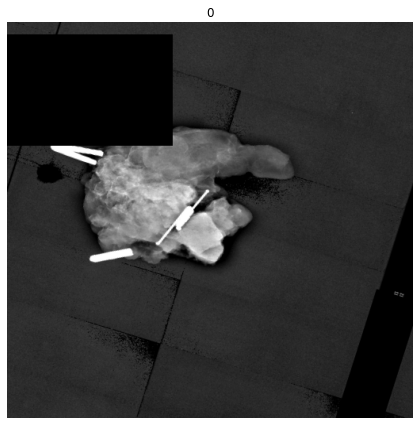

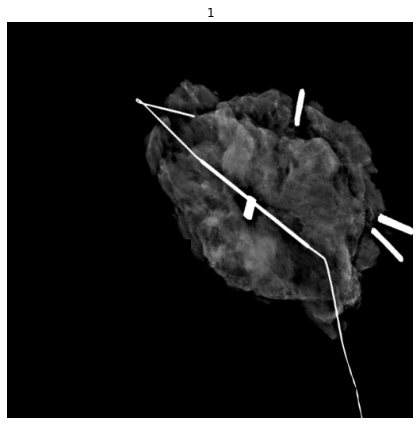

In [20]:
#view the first batch of images
for images, labels in train_ds.take(1):
    for i in range(4):
        #make the plots bigger
        plt.figure(figsize=(16, 16))
        #define the number of rows and columns
        rows = 2
        columns = 2
        #add subplot
        plt.subplot(rows, columns, i + 1)
        #plot the images
        plt.imshow(images[i].numpy().astype("uint8"), aspect='auto')
        plt.title(int(labels[i]))
        plt.axis("off")

In [21]:
if model_name == 'InceptionResNetV2':
    preprocess_fx = tf.keras.applications.inception_resnet_v2.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-IRV2_notop.h5"
    if weights == 'imagenet':
        base_model = InceptionResNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet', pooling='avg')
    elif weights == 'radimagenet':
        base_model = InceptionResNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir, pooling='avg')
elif model_name == 'ResNet50':
    preprocess_fx = tf.keras.applications.resnet50.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-ResNet50_notop.h5"
    if weights == 'imagenet':
        base_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet', pooling='avg')
    elif weights == 'radimagenet':
        base_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir, pooling='avg')
elif model_name == 'InceptionV3':
    preprocess_fx = tf.keras.applications.inception_v3.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-InceptionV3_notop.h5"
    if weights == 'imagenet':
        base_model = InceptionV3(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet', pooling='avg')
    elif weights == 'radimagenet':
        base_model = InceptionV3(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir, pooling='avg')
elif model_name == 'DenseNet121':
    preprocess_fx = tf.keras.applications.densenet.preprocess_input
    model_dir = "../RadImageNet/models/RadImageNet-DenseNet121_notop.h5"
    if weights == 'imagenet':
        base_model = DenseNet121(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet', pooling='avg')
    elif weights == 'radimagenet':
        base_model = DenseNet121(input_shape=(img_size, img_size, 3), include_top=False, weights=model_dir, pooling='avg')
elif model_name == 'Xception':
    preprocess_fx = tf.keras.applications.xception.preprocess_input
    if weights == 'imagenet':
        base_model = tf.keras.applications.Xception(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet', pooling='avg')
elif model_name == 'BiT':
    base_model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=False)
    preprocess_fx = tf.keras.applications.resnet50.preprocess_input
    


In [22]:


inputs = keras.Input(shape=(img_size, img_size, 3))
y = preprocess_fx(inputs)
y = base_model(y, training=False)
for i in range(n_layers):
    y = keras.layers.Dense(n_neurons, activation='relu')(y)
    y = keras.layers.Dropout(n_dropout)(y)
outputs = keras.layers.Dense(1, activation='sigmoid')(y)
model = keras.Model(inputs, outputs)

# %%
early_stopping = keras.callbacks.EarlyStopping(patience=20, min_delta=1e-10, restore_best_weights=True)

# %%

model.compile(
    optimizer=keras.optimizers.Adam(lr_1), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)

epochs = 1000


In [23]:
model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=early_stopping, verbose=1)
print('phase 1 complete')
# %%
#unfreeze all layers and train at lower learning rate
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(lr_2), 
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()],
)
model.fit(train_ds, epochs=1000, validation_data=val_ds, callbacks=early_stopping, verbose=1)
print('phase 2 complete')


Epoch 1/1000


2023-02-14 12:18:39.092535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-14 12:18:39.967492: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-02-14 12:18:39.970598: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-02-14 12:18:39.970614: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-02-14 12:18:39.970717: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

 1/31 [..............................] - ETA: 20:18 - loss: 0.6899 - binary_accuracy: 0.5625 - auc: 0.4286

2023-02-14 12:19:02.322719: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


31/31 [==============================] - 61s 671ms/step - loss: 0.6942 - binary_accuracy: 0.5142 - auc: 0.4849 - val_loss: 0.6910 - val_binary_accuracy: 0.5273 - val_auc: 0.5295
Epoch 2/1000
31/31 [==============================] - 16s 509ms/step - loss: 0.6919 - binary_accuracy: 0.5203 - auc: 0.5160 - val_loss: 0.6888 - val_binary_accuracy: 0.5273 - val_auc: 0.5875
Epoch 3/1000
31/31 [==============================] - 16s 510ms/step - loss: 0.6853 - binary_accuracy: 0.5488 - auc: 0.5753 - val_loss: 0.6812 - val_binary_accuracy: 0.5576 - val_auc: 0.6203
Epoch 4/1000
31/31 [==============================] - 17s 515ms/step - loss: 0.6840 - binary_accuracy: 0.5508 - auc: 0.5762 - val_loss: 0.6884 - val_binary_accuracy: 0.5455 - val_auc: 0.5589
Epoch 5/1000
31/31 [==============================] - 17s 526ms/step - loss: 0.6789 - binary_accuracy: 0.6057 - auc: 0.6168 - val_loss: 0.6796 - val_binary_accuracy: 0.5576 - val_auc: 0.6061
Epoch 6/1000
31/31 [==============================] - 17s 

In [24]:
# # %%
# #load test set and normalize using same code

# y_val_pred = np.array([])
# y_val = np.array([])
# for images, labels in val_ds:
#     y_val = np.append(y_val, labels.numpy())
#     y_val_pred = np.append(y_val_pred, model.predict(images))
# auroc_val = roc_auc_score(y_val, y_val_pred)

# y_test_pred = np.array([])
# y_test = np.array([])
# for images, labels in test_ds:
#     y_test = np.append(y_test, labels.numpy())
#     y_test_pred = np.append(y_test_pred, model.predict(images))
# auroc_test = roc_auc_score(y_test, y_test_pred)
# file_paths = test_ds.file_paths
# pred_df = pd.DataFrame({'file_path': file_paths, 'y_true': y_test, 'y_pred': y_test_pred})
# pred_df.to_csv('preds/preds_{}_{}.csv'.format(model_name, weights), index=False)

In [25]:
#save the final model as a .h5 file
model.save('models/{}_{}.h5'.format(model_name, weights))

In [27]:
#generate predictions for all images in the dataset, including train and val, and save to one csv
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='binary', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, label_mode='binary', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=batch_size, color_mode='rgb')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='binary', seed=0, shuffle=False, image_size=(img_size, img_size), batch_size=1, color_mode='rgb')
y_train_pred = np.array([])
y_train = np.array([])
for images, labels in train_ds:
    y_train = np.append(y_train, labels.numpy())
    y_train_pred = np.append(y_train_pred, model.predict(images))
train_file_paths = train_ds.file_paths

y_val_pred = np.array([])
y_val = np.array([])
for images, labels in val_ds:
    y_val = np.append(y_val, labels.numpy())
    y_val_pred = np.append(y_val_pred, model.predict(images))
val_file_paths = val_ds.file_paths

y_test_pred = np.array([])
y_test = np.array([])
for images, labels in test_ds:
    y_test = np.append(y_test, labels.numpy())
    y_test_pred = np.append(y_test_pred, model.predict(images))
test_file_paths = test_ds.file_paths

y_all_pred = np.append(y_train_pred, y_val_pred)
y_all_pred = np.append(y_all_pred, y_test_pred)
y_all = np.append(y_train, y_val)
y_all = np.append(y_all, y_test)
file_paths = np.append(train_file_paths, val_file_paths)
file_paths = np.append(file_paths, test_file_paths)
pred_df = pd.DataFrame({'file_path': file_paths, 'y_true': y_all, 'y_pred': y_all_pred})
pred_df.to_csv('../preds/preds_{}_{}_all_cutout.csv'.format(model_name, weights), index=False)


Found 492 files belonging to 2 classes.
Found 165 files belonging to 2 classes.
Found 164 files belonging to 2 classes.
1/1 [==============================] - 0s 50ms/step


In [28]:
auroc_test = roc_auc_score(y_test, y_test_pred)
auroc_val = roc_auc_score(y_val, y_val_pred)
print("test auroc: {}".format(auroc_test))
print("val auroc: {}".format(auroc_val))


test auroc: 0.7151162790697674
val auroc: 0.6196581196581196


In [ ]:
results_df = pd.DataFrame({'model': [model_name], 'weights': [weights], 'image_size': [img_size], 'batch_size': [batch_size], 'lr_1': [lr_1], 'lr_2': [lr_2], 'n_layers': [n_layers], 'n_neurons': [n_neurons], 'n_dropout': [n_dropout], 'auroc_val': auroc_val, 'auroc_test': auroc_test})